In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.transformations.series.outlier_detection import HampelFilter
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sklearn.preprocessing import StandardScaler
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.fourier import FourierFeatures

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.compose import make_reduction

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import TargetEncoder

from catboost import CatBoostRegressor

from sktime.transformations.compose  import TransformerPipeline
import shap as sp

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
pd.options.display.max_columns = None

# I/ Load Dataset

In [3]:
df = pd.read_csv('daily-website-visitors.csv')[["Date", "Page.Loads", "Unique.Visits", "First.Time.Visits", "Returning.Visits"]]

df = df.rename(columns={"Date": 'ds', 
                        "Page.Loads": 'y1',
                        "Unique.Visits": 'y2',
                        "First.Time.Visits": 'y3',
                        "Returning.Visits": 'y4'
                       })

In [4]:
targets = ['y1', 'y2', 'y3', 'y4']

In [5]:
df['ds'] = pd.to_datetime(df.ds, yearfirst = True)

for target in targets : 
    df[target] = df[target].str.replace(',','.').astype("float")

df = df.set_index('ds')
df.index.freq = 'd'

# II/ Pipeline Building

In [6]:
def CategoricalEncoding(X_tr, X_ts, y_tr=None, EncodingType='OHE', col=None):
    X_tr[f'type_{col}'] = X_tr.reset_index(col)[col].values
    X_ts[f'type_{col}'] = X_ts.reset_index(col)[col].values
    
    if EncodingType == 'OHE':
        ohe = OneHotEncoder(sparse_output=False).fit(X_tr[[f'type_{col}']])
        
        X_tr[ohe.get_feature_names_out([f'type_{col}'])] = ohe.transform(X_tr[[f'type_{col}']])
        X_ts[ohe.get_feature_names_out([f'type_{col}'])] = ohe.transform(X_ts[[f'type_{col}']])

        X_tr = X_tr.drop(f'type_{col}', axis=1)
        X_ts = X_ts.drop(f'type_{col}', axis=1)

    if EncodingType == 'Ordinal':
        le = OrdinalEncoder()
        
        X_tr[f'type_{col}'] = ohe.fit_transform(X_tr[[f'type_{col}']])
        X_ts[f'type_{col}'] = ohe.transform(X_ts[[f'type_{col}']])

    if EncodingType == 'Target':
        te = TargetEncoder(target_type='continuous', cv=2,)

        X_tr[f'type_{col}'] = te.fit_transform(X_tr[[f'type_{col}']], y_tr.values.ravel())
        X_ts[f'type_{col}'] = te.transform(X_ts[[f'type_{col}']])

    return X_tr, X_ts

In [7]:
filter_kwargs = {'window_length': 16, 'n_sigma': 3}

fourrier_kwargs = {'sp_list': [365.25, 7], 'fourier_terms_list': [10, 2], 'freq': 'D'}

window_kwargs =  {'lag_feature' : {
        "lag": list(range(1, 8)) + [14],
        "mean": [[1, 7], [1, 28], [7,14], [15, 21], [22,28]],
        "std": [[1, 7], [1, 28], [7,14], [15, 21], [22,28]],
    }
}

catboost_kwargs = {'loss_function': "RMSE", 'has_time': True, 'verbose': False}

forecast_kwargs = {'window_length': None, 'strategy': "recursive", 'pooling': 'global', 'scitype': 'tabular-regressor'}

In [8]:
fourier_featurizer = FourierFeatures(**fourrier_kwargs)

forecaster = make_reduction(CatBoostRegressor(**catboost_kwargs),
                            **forecast_kwargs,
                            transformers=[WindowSummarizer(**window_kwargs, )])

In [9]:
pipe = TransformedTargetForecaster(steps=[
        ("outlier", HampelFilter(**filter_kwargs)),
        ("imputer_interp", Imputer(method="linear")),
        ("imputer_extrap", Imputer(method="nearest")),
        ("boxcox", BoxCoxTransformer()),
        ("detrender", Detrender()),
        ("scale", TabularToSeriesAdaptor(StandardScaler())),
        ("forecaster", forecaster),

])

# III/ Pre-Preprocessing

In [10]:
y_train, y_test = temporal_train_test_split(df[targets], test_size=365)
index_train, index_test = y_train.index, y_test.index

In [11]:
y_train = pd.melt(y_train.reset_index(), id_vars=['ds'], value_vars=['y1', 'y2', 'y3', 'y4'], var_name='target', value_name='y').sort_values(by=['ds', 'target']).set_index(['target', 'ds'])
y_test = pd.melt(y_test.reset_index(), id_vars=['ds'], value_vars=['y1', 'y2', 'y3', 'y4'], var_name='target', value_name='y').sort_values(by=['ds', 'target']).set_index(['target', 'ds'])

In [12]:
y_train.head()

,,y
target,ds,
y1,2014-09-14,2.146
y2,2014-09-14,1.582
y3,2014-09-14,1.430
y4,2014-09-14,152.000
y1,2014-09-15,3.621


In [13]:
X_full = fourier_featurizer.fit_transform(df[target])
X_train, X_test = X_full.loc[index_train], X_full.loc[index_test]

In [14]:
X_tr = X_train.reset_index('ds').merge(pd.DataFrame(targets, columns=['target']), how='cross').set_index(['target', 'ds']).sort_values(by=['ds', 'target'])
X_ts = X_test.reset_index('ds').merge(pd.DataFrame(targets, columns=['target']), how='cross').set_index(['target', 'ds']).sort_values(by=['ds', 'target'])

In [15]:
X_tr, X_ts = CategoricalEncoding(X_tr, X_ts, y_train, 'Target', 'target')

In [16]:
X_tr.head()

,,sin_365.25_1,cos_365.25_1,sin_365.25_2,cos_365.25_2,sin_365.25_3,cos_365.25_3,sin_365.25_4,cos_365.25_4,sin_365.25_5,cos_365.25_5,sin_365.25_6,cos_365.25_6,sin_365.25_7,cos_365.25_7,sin_365.25_8,cos_365.25_8,sin_365.25_9,cos_365.25_9,sin_365.25_10,cos_365.25_10,sin_7_1,cos_7_1,sin_7_2,cos_7_2,type_target
target,ds,,,,,,,,,,,,,,,,,,,,,,,,,
y1,2014-09-14,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.00000,0.000000,1.00000,0.000000,1.000000,4.035096
y2,2014-09-14,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.00000,0.000000,1.00000,0.000000,1.000000,16.563040
y3,2014-09-14,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.00000,0.000000,1.00000,0.000000,1.000000,42.616331
y4,2014-09-14,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.00000,0.000000,1.00000,0.000000,1.000000,518.635493
y1,2014-09-15,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669,0.068755,0.997634,0.085906,0.996303,0.103031,0.994678,0.120126,0.992759,0.137185,0.990545,0.154204,0.988039,0.171177,0.98524,0.781831,0.62349,0.974928,-0.222521,4.167287


# IV/ Fitting

In [17]:
pipe.fit(y_train, X_tr)

TransformedTargetForecaster(steps=[('outlier', HampelFilter(window_length=16)),
                                   ('imputer_interp', Imputer(method='linear')),
                                   ('imputer_extrap',
                                    Imputer(method='nearest')),
                                   ('boxcox', BoxCoxTransformer()),
                                   ('detrender', Detrender()),
                                   ('scale',
                                    TabularToSeriesAdaptor(transformer=StandardScaler())),
                                   ('forecaster',
                                    RecursiveTabularRegressionForecaster(estimator=<catboost.core.CatBoostRegressor object at 0x000001A5272D5ED0>,
                                                                         pooling='global',
                                                                         transformers=[WindowSummarizer(lag_feature={'lag': [1,
                                                                                                                             2,
                                                                                                                             3,
                                                                                                                             4,
                                                                                                                             5,
                                                                                                                             6,
                                                                                                                             7,
                                                                                                                             14],
                                                                                                                     'mean': [[1,
                                                                                                                               7],
                                                                                                                              [1,
                                                                                                                               28],
                                                                                                                              [7,
                                                                                                                               14],
                                                                                                                              [15,
                                                                                                                               21],
                                                                                                                              [22,
                                                                                                                               28]],
                                                                                                                     'std': [[1,
                                                                                                                              7],
                                                                                                                             [1,
                                                                                                                              28],
                                                                                                                             [7,
                                                                                                                              14],
                                                 

In [18]:
y_pred = pipe.predict(np.arange(1,366).tolist(), X_ts)

# V/ Result

Newtech:
MSE: 0.301073960111024
MAPE: 0.10699948386807785


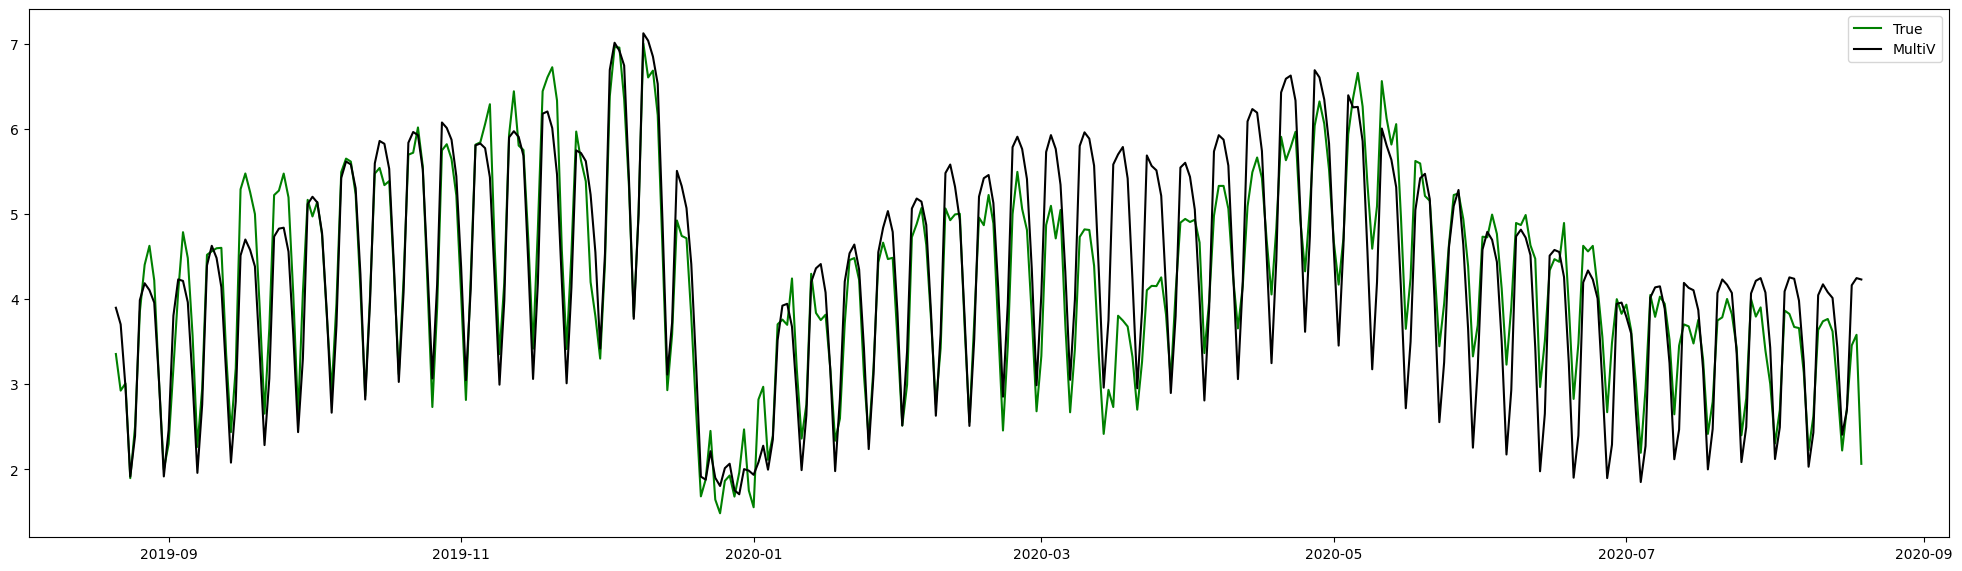

Newtech:
MSE: 0.19997585147213537
MAPE: 0.11612806431654502


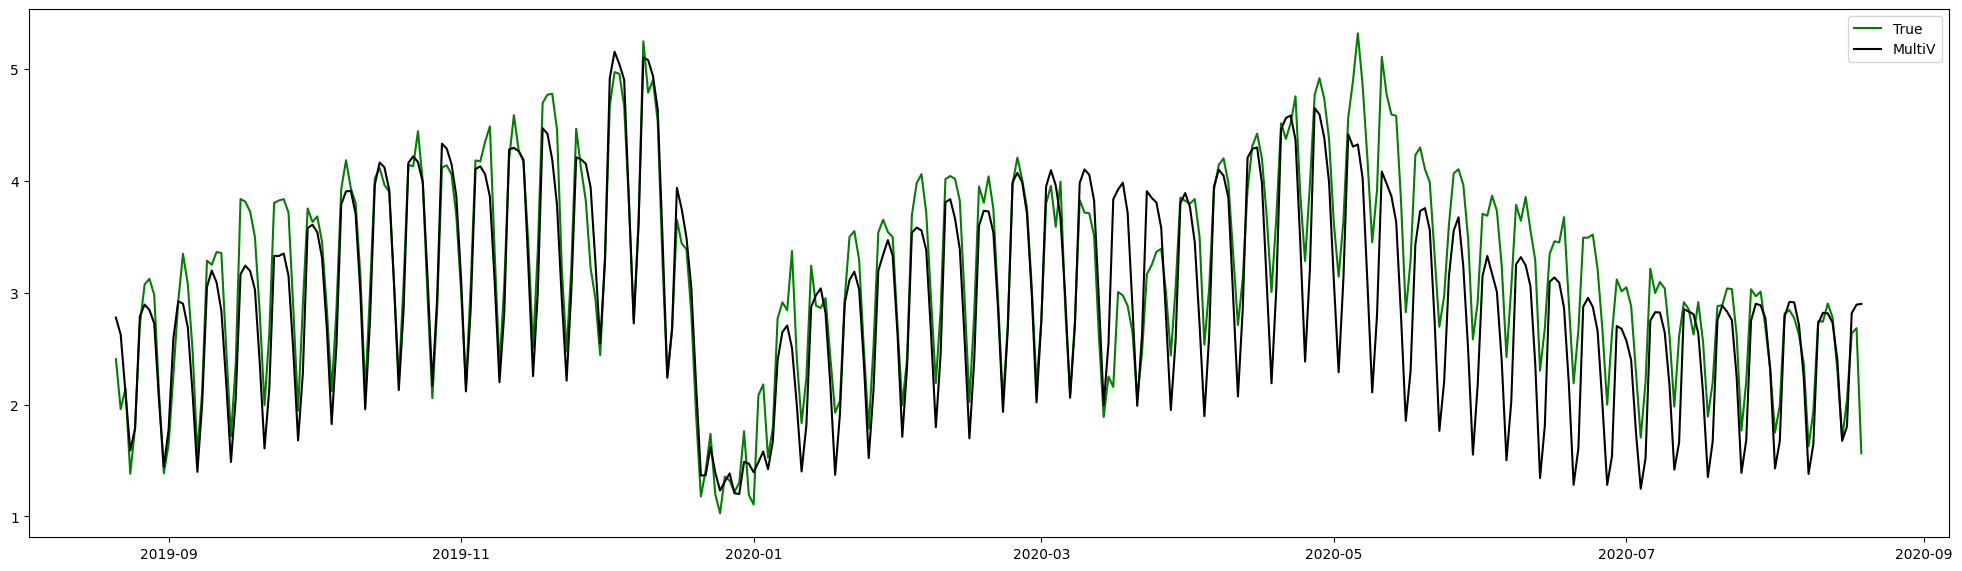

Newtech:
MSE: 6656.06201992727
MAPE: 0.15220058955374466


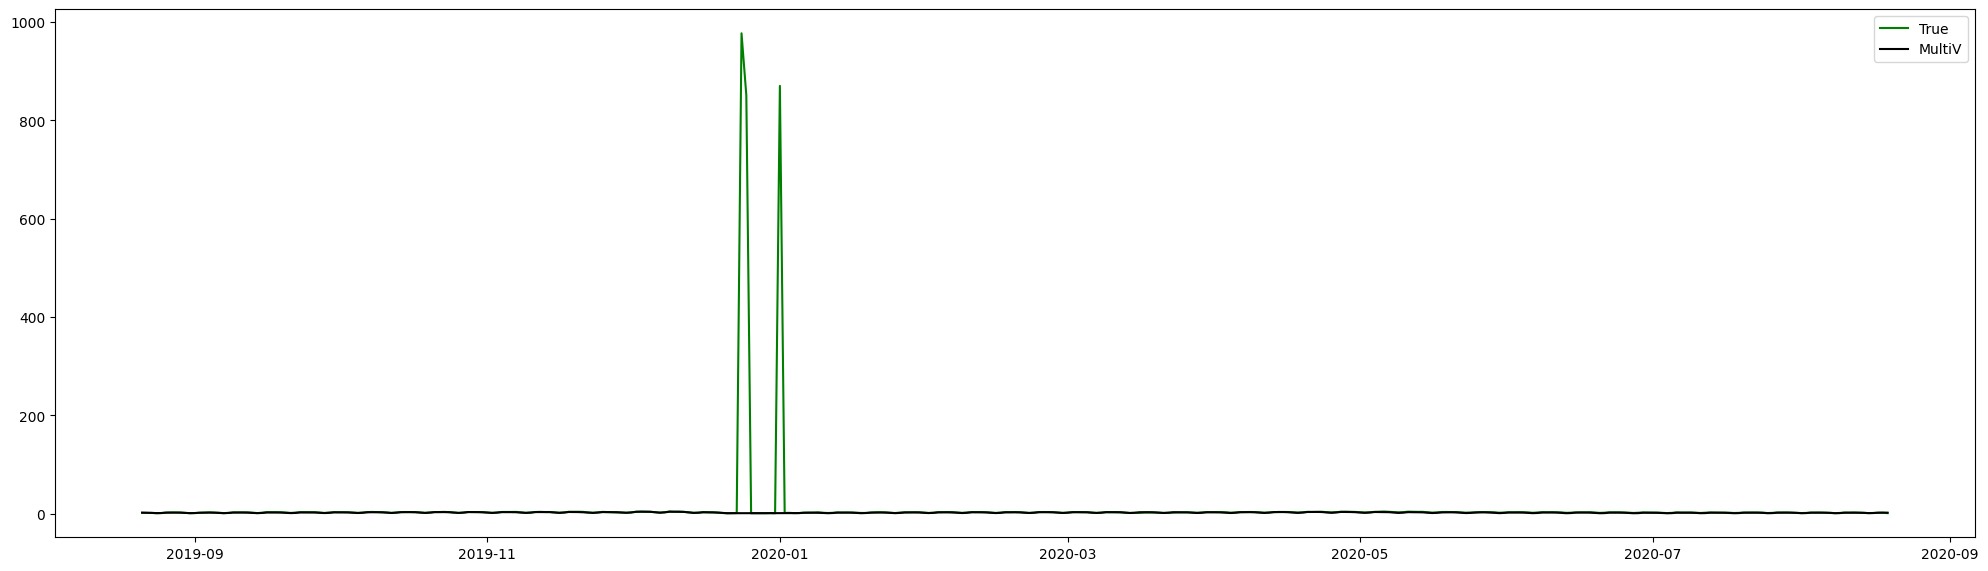

Newtech:
MSE: 10794.479222342754
MAPE: 0.18304744589150096


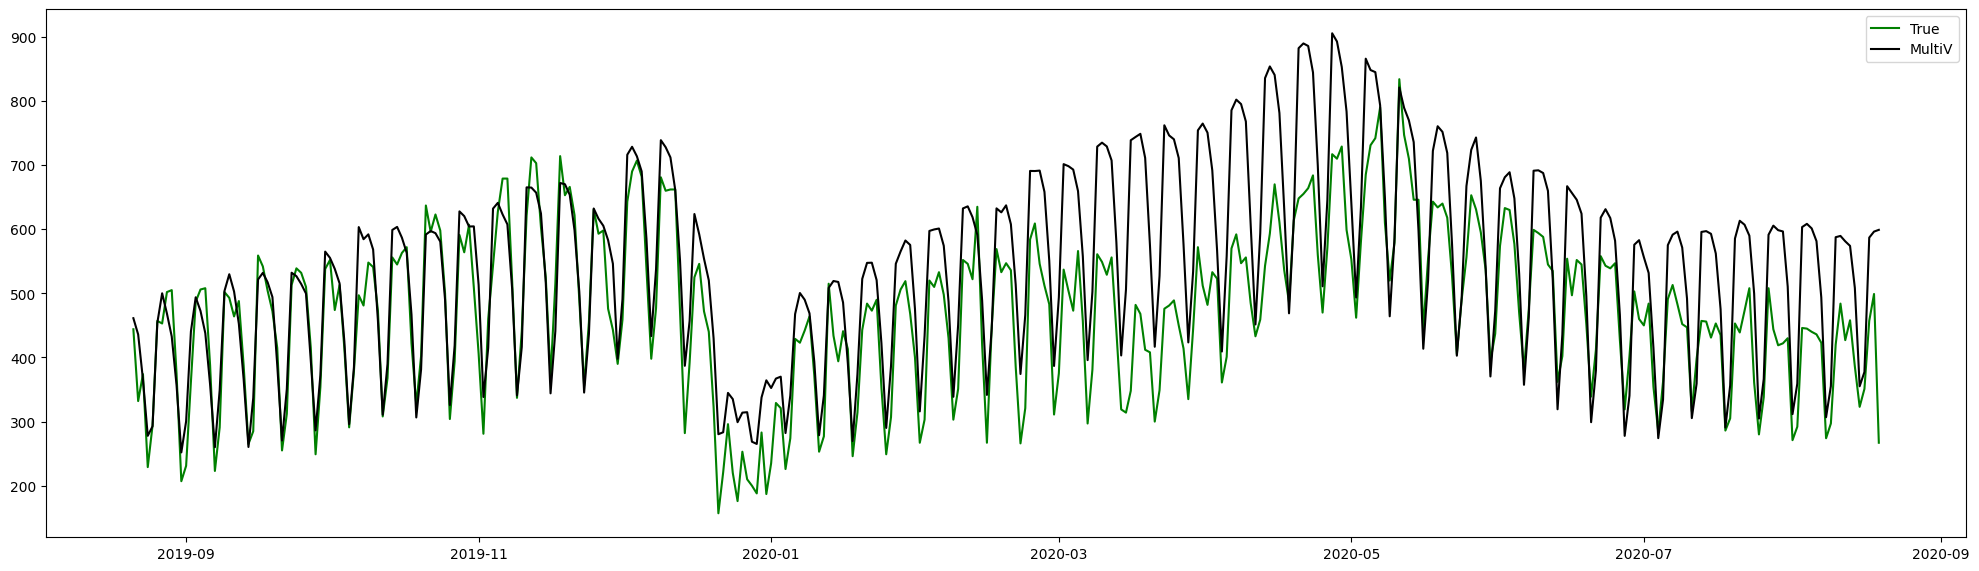

In [19]:
for target in targets:
    y_test_tmp = y_test.loc[target]
    y_pred_tmp = y_pred.loc[target]
    
    print('Newtech:')
    print("MSE:", mean_squared_error(y_test_tmp, y_pred_tmp))
    print("MAPE:", mean_absolute_percentage_error(y_test_tmp, y_pred_tmp))

    plt.plot(y_test_tmp.index, y_test_tmp.values, color='green', label = 'True')
    plt.plot(y_pred_tmp.index,  y_pred_tmp.values, color='black', label='MultiV')

    plt.legend()
    plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)
    plt.show()

# VI/ Model explicativity

In [20]:
model_sp = pipe.get_fitted_params()['forecaster'].get_fitted_params()['estimator']

In [21]:
from sktime.transformations.compose  import TransformerPipeline

pipe_sp = TransformerPipeline(steps=[
    ("outlier", HampelFilter(**filter_kwargs)),
    ("imputer_interp", Imputer(method="linear")),
    ("imputer_extrap", Imputer(method="nearest")),
    ("boxcox", BoxCoxTransformer()),
    ("detrender", Detrender()),
    ("scale", TabularToSeriesAdaptor(StandardScaler())),
])

y_sp = pipe_sp.fit_transform(y_train)

In [22]:
X_sp = pd.concat([WindowSummarizer(**window_kwargs, ).fit_transform(y_sp), X_tr])
X_sp =X_sp[model_sp.feature_names_]

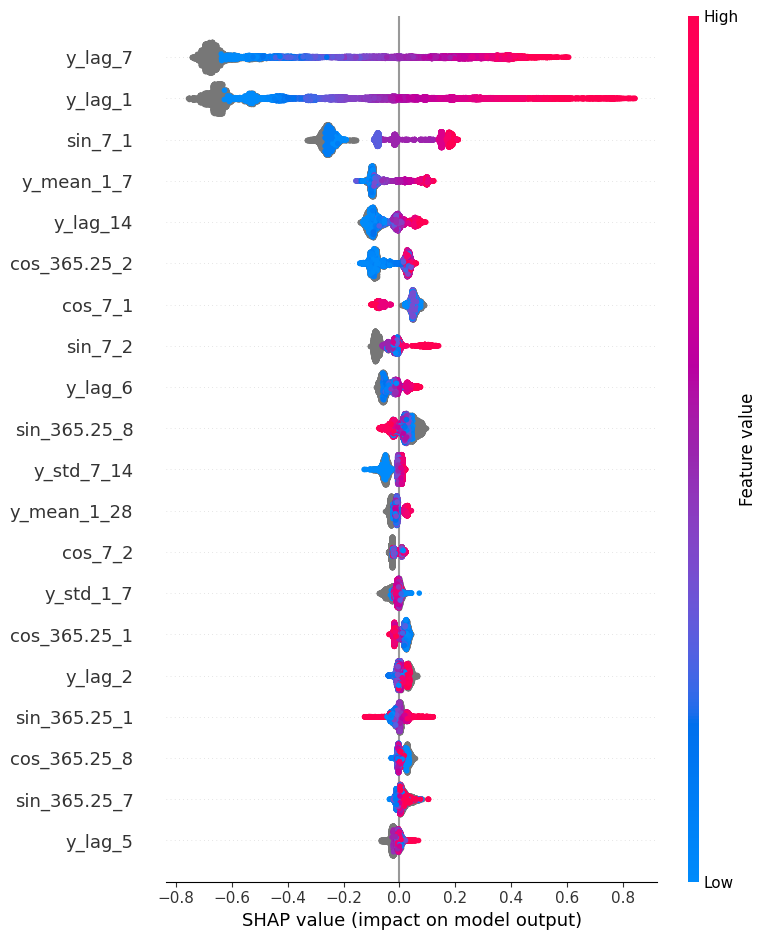

In [23]:
explainer = sp.TreeExplainer(model_sp)
shap_values = explainer.shap_values(X_sp)

sp.summary_plot(shap_values, X_sp, max_display=20)
plt.show()